# Data exploration of CyTOF sets
MULTICENTER

In [1]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
from sklearn.metrics import f1_score
import os
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import KFold
import collections

## Sample of data

In [2]:
sample = pd.read_csv("../Data/MultiCenter/Samples/sample01.csv", header=None)
markers = ['CCR6','CD20','CD45','CD14','CD16','CD8','CD3','CD4']
sample.columns = markers

sample.head(10)

,CCR6,CD20,CD45,CD14,CD16,CD8,CD3,CD4
0,17.890000,10.2310,790.55,2.7417,0.00000,1.065300,179.600000,45.0630
1,0.000000,4.6372,1112.70,468.4100,0.25689,2.436200,1.781100,13.5060
2,0.002912,7.2418,1294.20,624.2500,0.00000,0.493150,2.351400,2.0904
3,2.911800,2.7268,1321.20,579.8200,0.00000,0.910060,1.575700,8.3613
4,0.000000,4.5986,778.36,0.0000,0.00000,0.000000,253.720000,38.5670
5,501.770000,921.6700,934.45,2.6003,0.00000,0.043438,2.614300,1.7870
6,0.753110,2.8833,964.34,383.8900,4.11720,0.000000,3.513200,1.4420
7,0.157420,0.0000,748.81,80.8760,1.59330,4.550900,4.110600,5.1319
8,0.000000,1.7064,965.98,1.4520,65.13400,0.186930,0.008875,0.0000
9,0.000000,2.5197,1308.40,0.2186,16.53700,83.937000,4.547600,1.5487


In [3]:
#Declare variables for data acquisition from CSV results
labelfiles = os.listdir("../Data/MultiCenter/Labels/")
samplefiles = os.listdir("../Data/MultiCenter/Samples/")
labelfiles.sort()
samplefiles.sort()
F1list = []
Acclist = []
predictfiles = os.listdir("../Results/Predictions/MultiCenter LDA/CV-sample")
predictfiles.sort()
truedict = collections.OrderedDict()
preddict = collections.OrderedDict()

In [4]:
#Data acquisition from CSV results

for i in range(len(samplefiles)):
    #Calculate F1 & accuracy scores for each prediciton
    true = list(pd.read_csv("../Data/MultiCenter/Labels/" + labelfiles[i], header=None, engine='python').values.ravel())
    predicted = list(pd.read_csv("../Results/Predictions/MultiCenter LDA/CV-sample/" + predictfiles[i], header=None, engine='python').values.ravel())
    F1list.append(metrics.f1_score(y_true=true, y_pred=predicted, average='weighted'))
    Acclist.append(metrics.accuracy_score(true, predicted))
    #Calculate counts of all original labels
    unique, counts = np.unique(true, return_counts=True)
    temp = dict(zip(unique, counts))
    for celltype in temp:
        try:
            truedict[celltype] += temp[celltype]
        except KeyError:
            truedict[celltype] = temp[celltype]
    #Calculate counts of all predicted labels
    unique, counts = np.unique(predicted, return_counts=True)
    temp = dict(zip(unique, counts))
    for celltype in temp:
        try:
            preddict[celltype] += temp[celltype]
        except KeyError:
            preddict[celltype] = temp[celltype]

## CV-sample stats

In [5]:
instancecount =0
for key in preddict:
    instancecount += truedict[key]
print('Number of cell predictions made: %i' % instancecount)
instancecount =0
for key in preddict:
    instancecount += truedict[key]
print('Original number of true labels: %i' % instancecount)


Number of cell predictions made: 929685
Original number of true labels: 929685


In [13]:
truedict

OrderedDict([(0, 236042), (1, 76101), (2, 154913), (3, 92558), (4, 370071)])

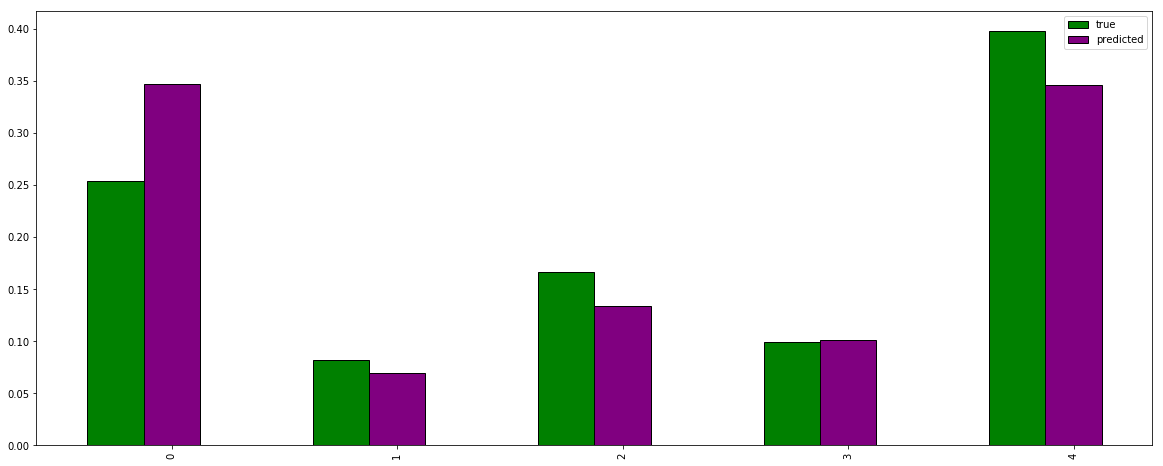

In [7]:
#increase plotsize
plt.rcParams['figure.figsize'] = [20, 8]
# set width of bars
barWidth = 0.25
# set height of bars
truedict = collections.OrderedDict(sorted(truedict.items()))
preddict = collections.OrderedDict(sorted(preddict.items()))
bars = [[dictionary[key] for key in dictionary] for dictionary in [truedict, preddict]]
for x in range(len(bars)):
    total = sum(bars[x])
    for y in range(len(bars[x])):
        bars[x][y] = bars[x][y] / total
#set bar x coords
r1 = np.arange(4)
r2 = r1 + 0.25
#plot bars & ticks
plt.bar(r1, bars[0], color='green', width=barWidth, edgecolor='black', label='true')
plt.bar(r2, bars[1], color='purple', width=barWidth, edgecolor='black', label='predicted')
plt.xticks([r + barWidth for r in range(len(bars[0]))], truedict.keys(), rotation='vertical' )
plt.legend()
plt.show()

In [8]:
truedict = collections.OrderedDict(sorted(truedict.items()))


In [9]:
F1median = np.median(F1list)
Accmean = np.mean(Acclist) * 100
Accstd = np.std(Acclist) * 100
print('MULTICENTER CV-samples')
print('Accuracy mean: %s' % round(Accmean, 2))
print('Accuracy std: %s' % round(Accstd, 2))
print('F1 median: %s' % round(F1median, 2))

HMIS-2 CV-samples
Accuracy mean: 86.06
Accuracy std: 3.39
F1 median: 0.87


## CV-cells stats

In [10]:
#Load all labels for 5-cold CV performance
predictlabels = pd.DataFrame()
truelabels = pd.DataFrame()

for batch in range(1, 6):
    predictlabels = predictlabels.append(pd.read_csv("../Results/Predictions/MultiCenter LDA/CV-cells/" + 'predict_batch_' + str(batch) +'.csv',
                                          header=None, engine='python'))
for filename in labelfiles:
    truelabels = truelabels.append(pd.read_csv("../Data/MultiCenter/Labels/" + filename, header=None))



## Calculate accuracies and F1 scores for 5 fold

In [11]:
F1list  = []
Acclist = []

kfoldsplitter = KFold(n_splits=5, shuffle=True, random_state=1)
for train, test in kfoldsplitter.split(predictlabels):
    true = truelabels.iloc[test].values.ravel()
    pred = predictlabels.iloc[test].values.ravel()
    F1list.append(metrics.f1_score(true, pred, average='weighted'))
    Acclist.append(metrics.accuracy_score(true, pred))

In [12]:
F1median = np.median(F1list)
Accmean = np.mean(Acclist) * 100
Accstd = np.std(Acclist) * 100
print('MultiCenter CV-cells')
print('Accuracy mean: %s' % round(Accmean, 2))
print('Accuracy std: %s' % round(Accstd, 2))
print('F1 median: %s' % round(F1median, 2))

MultiCenter CV-cells
Accuracy mean: 80.32
Accuracy std: 0.07
F1 median: 0.81
